In [1]:
"""
Reduce Memory Usage by 75%
https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day
"""

## Reduce Memory

def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
#                 reducing float16 for calculating numpy.nanmean
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df


In [2]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
# !pip install kerastuner
# import kerastuner as kt
from keras import layers
import tensorflow_addons as tfa

# from kerastuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px 
import matplotlib.gridspec as gridspec
from  collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE as tsne
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import gc
import pickle
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import roc_curve,auc,roc_auc_score
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.model_selection import KFold

/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# The root path
path = "/kaggle/input/jane-street-market-prediction/"
# path = ''

# Load the training datas.
train = pd.read_csv(path + "train.csv")
train = reduce_memory_usage(train)

# Load the metadata pertaining to the anonymized features.
features = pd.read_csv(path + "features.csv")

Memory usage of dataframe is 2516.843978881836 MB
Memory usage of dataframe after reduction 1247.0233011245728 MB
Reduced by 50.45289610369131 % 


In [5]:
# Display missing values per column

missing_table = pd.DataFrame({c:(train[c].isna().sum()/len(train))*100 for c in train.columns},index=["% missing values"])

missing_table

date  weight  resp_1  resp_2  resp_3  resp_4  resp  \
% missing values   0.0     0.0     0.0     0.0     0.0     0.0   0.0   

                  feature_0  feature_1  feature_2  ...  feature_121  \
% missing values        0.0        0.0        0.0  ...     2.922161   

                  feature_122  feature_123  feature_124  feature_125  \
% missing values     0.009329     0.009329     0.672791     0.672791   

                  feature_126  feature_127  feature_128  feature_129  ts_id  
% missing values     0.370342     0.370342      0.08036      0.08036    0.0  

[1 rows x 138 columns]

In [6]:
# Compute the correlation between pair features.

correlation_table = train[[train.columns[i] for i in range(2,137)]].corr()

In [7]:
# Display the correlation table of pair features.
correlation_table


resp_1    resp_2    resp_3    resp_4      resp  feature_0  \
resp_1       1.000000  0.890214  0.678381  0.358949  0.452159  -0.005225   
resp_2       0.890214  1.000000  0.823383  0.469230  0.595274  -0.011439   
resp_3       0.678381  0.823383  1.000000  0.805952  0.815972  -0.003427   
resp_4       0.358949  0.469230  0.805952  1.000000  0.956197  -0.013900   
resp         0.452159  0.595274  0.815972  0.956197  1.000000  -0.023726   
...               ...       ...       ...       ...       ...        ...   
feature_125  0.010208  0.007413  0.002907 -0.001690 -0.001211  -0.000013   
feature_126  0.034311  0.030119  0.022115  0.015990  0.019669   0.014965   
feature_127  0.012399  0.009378  0.004440 -0.000614  0.000084   0.000141   
feature_128  0.036101  0.031239  0.022653  0.016156  0.019902   0.015261   
feature_129  0.013916  0.010492  0.005377  0.000227  0.000985   0.000569   

             feature_1  feature_2  feature_3  feature_4  ...  feature_120  \
resp_1        0.052593   0.040352   0.019656   0.017653  ...     0.031172   
resp_2        0.040820   0.029895   0.019778   0.018396  ...     0.027566   
resp_3        0.027175   0.019369  -0.002900  -0.000158  ...     0.020578   
resp_4        0.015942   0.009707  -0.008157  -0.008646  ...     0.015119   
resp          0.019802   0.011883   0.003608   0.000500  ...     0.018552   
...                ...        ...        ...        ...  ...          ...   
feature_125  -0.033898   0.060913   0.003318   0.007644  ...     0.194412   
feature_126   0.444440   0.198910   0.035190   0.018581  ...     0.940733   
feature_127  -0.029859   0.066827   0.006319   0.011980  ...     0.153538   
feature_128   0.438417   0.200525   0.037467   0.021256  ...     0.902448   
feature_129  -0.025186   0.071484   0.010335   0.016994  ...     0.103782   

             feature_121  feature_122  feature_123  feature_124  feature_125  \
resp_1          0.008115     0.038014     0.015601     0.033879     0.010208   
resp_2          0.005861     0.032482     0.011600     0.029830     0.007413   
resp_3          0.002388     0.023501     0.006365     0.021938     0.002907   
resp_4         -0.001891     0.016562     0.001094     0.015845    -0.001690   
resp           -0.001682     0.020313     0.001857     0.019478    -0.001211   
...                  ...          ...          ...          ...          ...   
feature_125     0.923079     0.176827     0.763360     0.223518     1.000000   
feature_126     0.154048     0.944771     0.174386     0.981306     0.215469   
feature_127     0.834156     0.221086     0.839202     0.206512     0.959696   
feature_128     0.131156     0.983554     0.261358     0.942911     0.190535   
feature_129     0.718403     0.284495     0.951103     0.155834     0.845525   

             feature_126  feature_127  feature_128  feature_129  
resp_1          0.034311     0.012399     0.036101     0.013916  
resp_2          0.030119     0.009378     0.031239     0.010492  
resp_3          0.022115     0.004440     0.022653     0.005377  
resp_4          0.015990    -0.000614     0.016156     0.000227  
resp            0.019669     0.000084     0.019902     0.000985  
...                  ...          ...          ...          ...  
feature_125     0.215469     0.959696     0.190535     0.845525  
feature_126     1.000000     0.238846     0.976216     0.208569  
feature_127     0.238846     1.000000     0.237858     0.930648  
feature_128     0.976216     0.237858     1.000000     0.278017  
feature_129     0.208569     0.930648     0.278017     1.000000  

[135 rows x 135 columns]

In [8]:
def detect_correlated_features(df,threshold=0.5):
    """This function will try detect features who have correlation grower than the introduced 
     threshold value.
     
     @param df(DataFrame): The dataframe who resume the correlation values between features.
     @param threshold(int) : the threshold that the function, will use as reference to detect
                             correlated features.
     @return list(List): list of tuple, who resume features that have correlation grower than
                           the introduced threshold.
     """
    correlated= defaultdict(list)
    for col in df.columns:
        dex = list(df.columns).index(col)
        for ind in df.index[dex+1:] :
            if df.loc[col,ind] > threshold:
               correlated[col].append (ind)
                
    return correlated

In [9]:
correlated_features = detect_correlated_features(correlation_table,threshold=0.9)


In [10]:
# Display a table showing the high correlated features.
ax_features = correlated_features.keys()
ay_features = []
for f in correlated_features.values():
    ay_features.extend(f)
ay_features = np.unique(ay_features)


<AxesSubplot:>

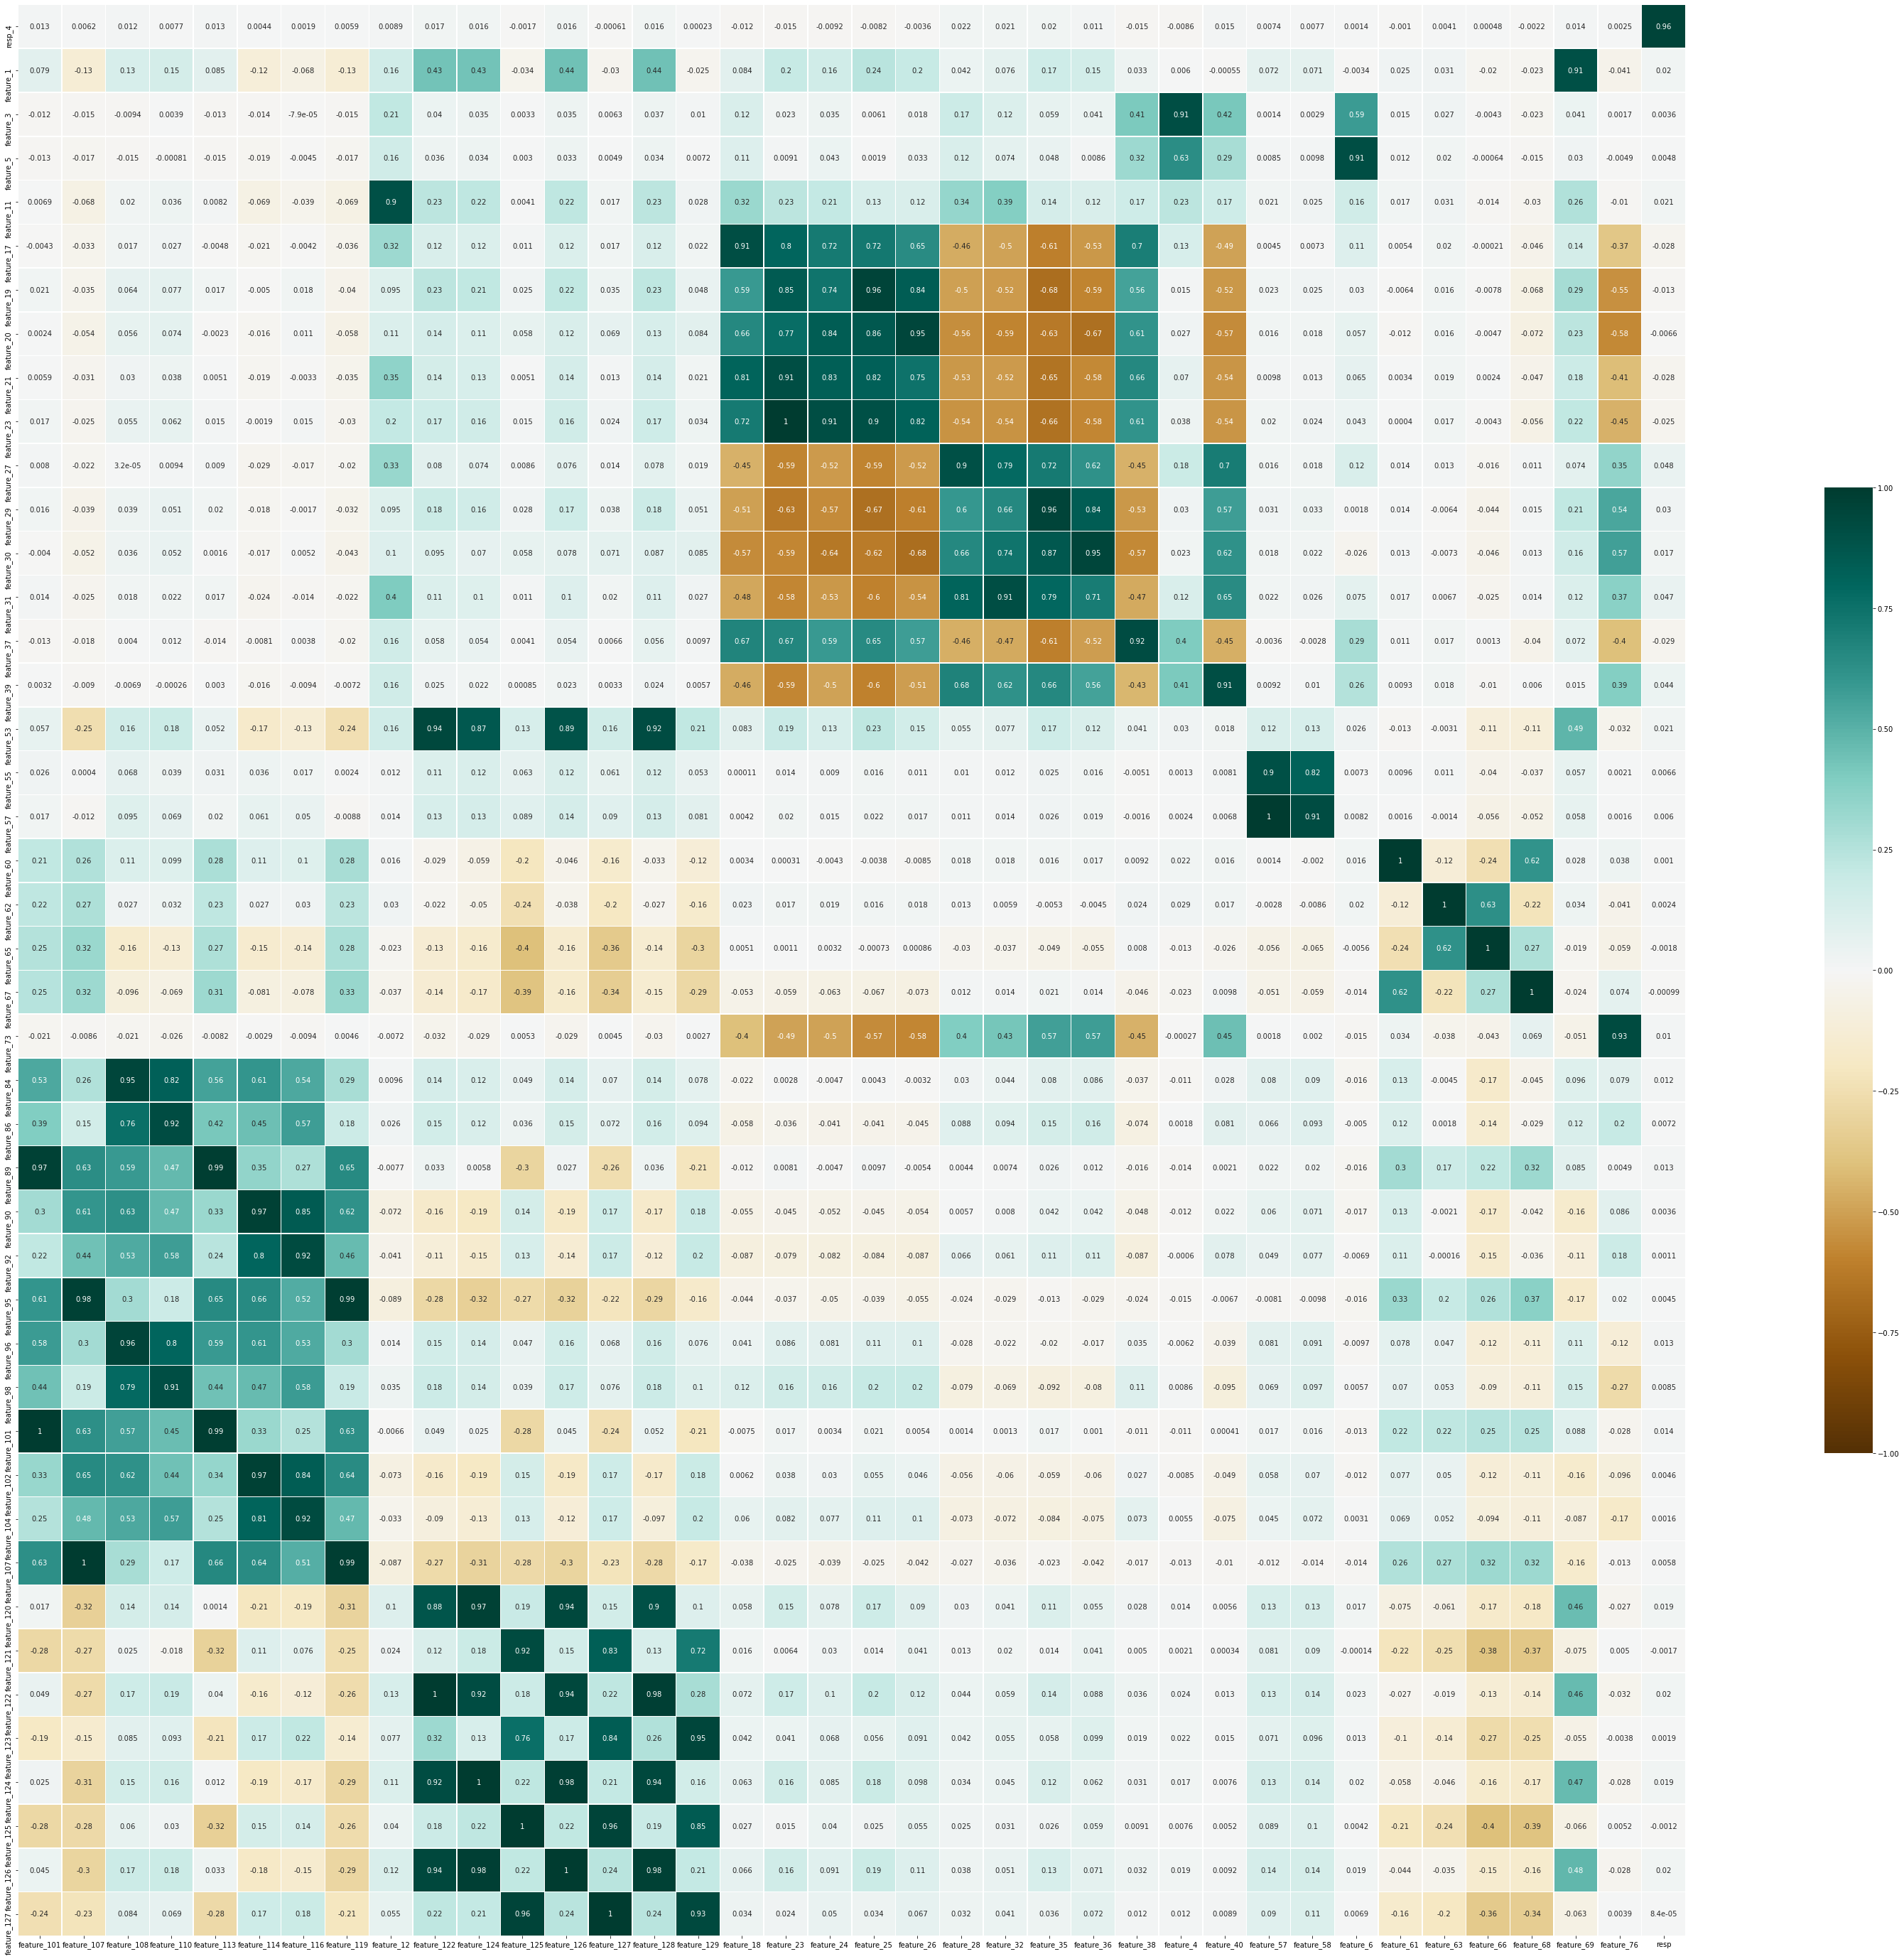

In [11]:
# Set up the matplotlib figure
f , ax = plt.subplots(figsize=(70,50))
sns.heatmap(correlation_table.loc[ax_features,ay_features],cmap='BrBG',annot=True,square=True,vmin=-1,vmax=1,\
            linewidths=0.5,cbar_kws={"shrink": .5})

In [12]:
# List of features to drop because of they are highly correlated 
# with others features in the train dataset.
features_to_drop = [f for f in ay_features if f not in ax_features]

In [13]:
# train datas after removing features assigned to drop list of columns.
train_df = train[[ f for f in list(train.columns) if ((f not in features_to_drop) or (f =="resp"))]]

In [14]:
# Compute the correlation betwen the features named resp, and the reste of features
label_correlation = pd.DataFrame({c:train_df["resp"].corr(train_df[c]) for\
                                  c in train_df.columns if c!="resp" and c!="feature_0"},index=["action"])

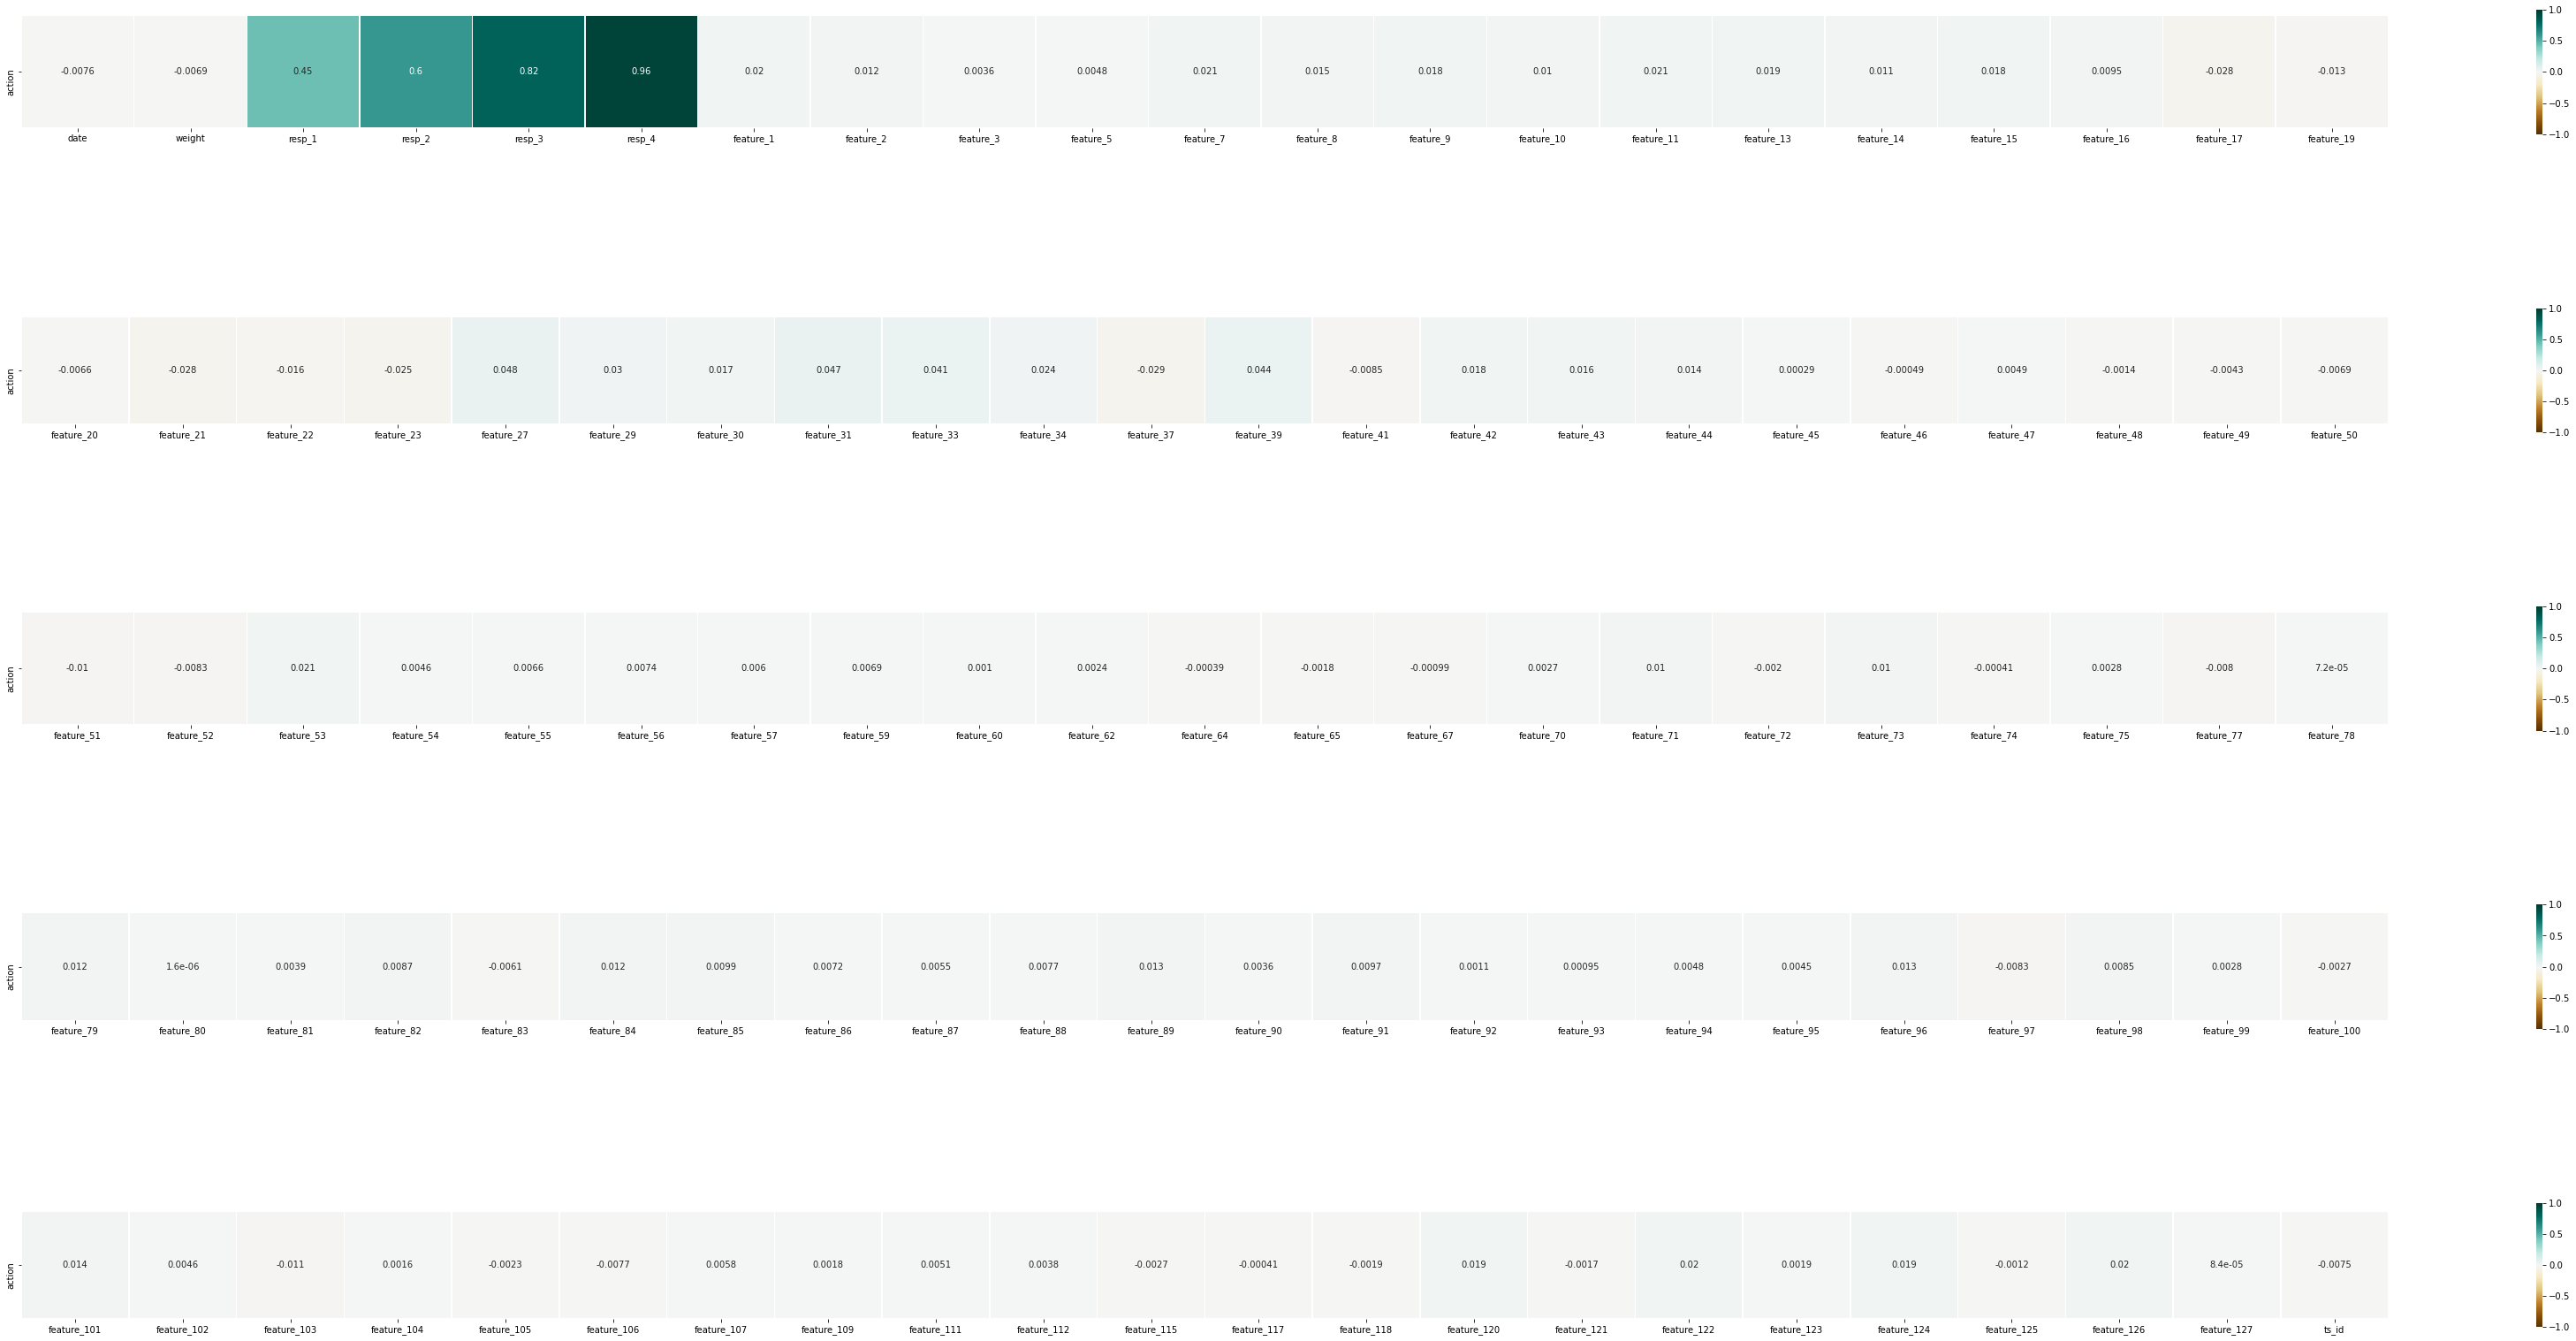

In [15]:
# Visualize the correlation in a table named label_correlation.
l = len(list(label_correlation.columns)) # compute the number  of features for label_correlation dataset
col = list(label_correlation.columns) # list of columns names of label_correlation dataset

# Because of , the high number of features in our dataset, we will try divide them into 5,
# in order to get more clear chart.
fig ,axes = plt.subplots(nrows=5,ncols=1,figsize=(60,30))
level = [0,int(l/5),int(2*l/5),int(3*l/5),int(4*l/5),l]
for i in range(len(level)-1):
    sns.heatmap(label_correlation.loc[:,col[level[i]:level[i+1]]],annot=True,cmap='BrBG',\
                linewidths=0.5,vmin=-1,vmax=1,cbar_kws={"shrink": .5},square=True,ax=axes[i])

Except resp_{1,2,3,4} values that represent returns over different time horizons, there is no evident linear relation between retained features and the feature of return.

The total correlation between feature_0 and the target equal to 1.2941016598751518


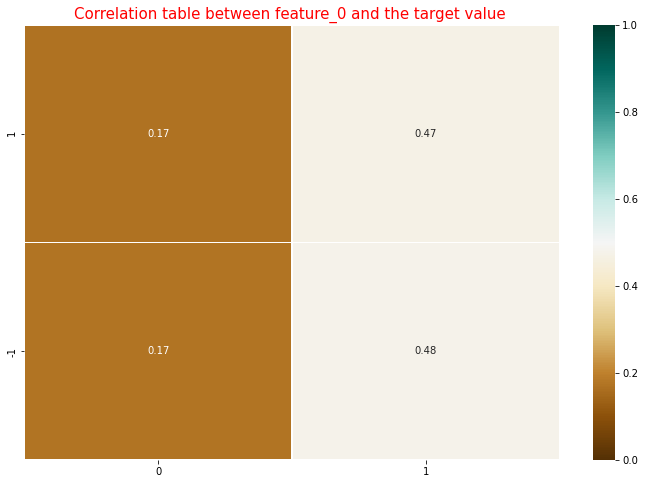

In [16]:
# correlation between the binary feature named feature_0 and the target values.
train_df.loc[:,"target"] = list(((train_df["resp"] > 0) & (train_df["resp_1"] >0) & (train_df["resp_2"]>0)\
                     & (train_df["resp_3"]>0) & (train_df["resp_4"]>0)).astype("int"))
train_df.loc[:,"vl"] = list(train_df["target"].values)
pvt_table=train_df[["feature_0","target"]].pivot_table(index=["feature_0"],columns=["target"],aggfunc=len)
#nb_1 = len(train_df.loc[train_df["target"]==1,:])
#nb_0 = len(train_df.loc[train_df["target"]==0,:])
#pvt_table[1] = pvt_table[1]/nb_1
#pvt_table[0] = pvt_table[0]/nb_0
tx= train_df["feature_0"].value_counts()
ty = train_df["target"].value_counts() 
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
n = len(train_df)
tx.columns = ["values"]
ty.columns = ["values"]

cnt = tx.dot(ty.T)/n
ind = cnt.index
pvt_table = pvt_table.loc[ind,:]
mesure = (cnt - pvt_table)**2/cnt
xin = mesure.sum().sum()

del(train_df["target"])
del(train_df["vl"])
#del(nb_1)
#del(nb_0)
fig = plt.figure(figsize=(12,8))
sns.heatmap(mesure,annot=True,linewidths=0.5,cmap="BrBG",vmin=0,vmax=1)
plt.title("Correlation table between feature_0 and the target value ",size=15,color="red")
print("The total correlation between feature_0 and the target equal to {}".format(xin))

In [17]:
train.head()

date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0     0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2     0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3     0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

   feature_0  feature_1  feature_2  ...  feature_121  feature_122  \
0          1  -1.872746  -2.191242  ...          NaN     1.168391   
1         -1  -1.349537  -1.704709  ...          NaN    -1.178850   
2         -1   0.812780  -0.256156  ...          NaN     6.115747   
3         -1   1.174379   0.344640  ...          NaN     2.838853   
4          1  -3.172026  -3.093182  ...          NaN     0.344850   

   feature_123  feature_124  feature_125  feature_126  feature_127  \
0     8.313582     1.782433    14.018213     2.653056    12.600291   
1     1.777472    -0.915459     2.831612    -1.417010     2.297459   
2     9.667908     5.542871    11.671595     7.281757    10.060014   
3     0.499251     3.033731     1.513488     4.397532     1.266037   
4     4.101145     0.614252     6.623456     0.800129     5.233243   

   feature_128  feature_129  ts_id  
0     2.301488    11.445807      0  
1    -1.304614     1.898684      1  
2     6.638248     9.427299      2  
3     3.856384     1.013469      3  
4     0.362636     3.926633      4  

[5 rows x 138 columns]

In [18]:
# Display train_df missing values before imputations.
missing_b_imputation = pd.DataFrame({c:(train_df[c].isna().sum()) for c in train_df.columns},index=["% missing values"])
print("The number of missing values in the train_df dataframe before imputation processing :{}".format(\
                                                                                                      missing_b_imputation.sum().sum()))
missing_b_imputation

The number of missing values in the train_df dataframe before imputation processing :4926085


date  weight  resp_1  resp_2  resp_3  resp_4  resp  \
% missing values     0       0       0       0       0       0     0   

                  feature_0  feature_1  feature_2  ...  feature_118  \
% missing values          0          0          0  ...         6683   

                  feature_120  feature_121  feature_122  feature_123  \
% missing values        69854        69854          223          223   

                  feature_124  feature_125  feature_126  feature_127  ts_id  
% missing values        16083        16083         8853         8853      0  

[1 rows x 110 columns]

In [19]:
# identify , which column has missing values in the new dataset named train_df

features_with_missing_values = [] # list of features , has missing values.
    
for f in list(train_df.columns):
    if missing_table.loc["% missing values",f] > 0 :
        features_with_missing_values.append(f)

In [20]:
# train a linear model regression for each feature, had missing values with his one of correlated
# feature
for f in features_with_missing_values :
    model = LinearRegression()
    if  len(correlated_features[f]) > 0 :
        correlated = correlated_features[f][0]
        if correlated in train.columns :
           model.fit(train.loc[(train[correlated].notna()) & (train[f].notna()),correlated].values.reshape(-1,1),\
              train.loc[(train[correlated].notna()) & (train[f].notna()),f])
           values_to_impute = train_df.loc[(train[f].isna()) & (train[correlated].notna()),f]
           imputer = train.loc[(train[f].isna())&(train[correlated].notna()),correlated].values
           if (len(values_to_impute) > 0) & (len(imputer) > 0) :
              train_df.loc[(train[f].isna()) & (train[correlated].notna()),f] = model.predict(train.loc[(train[f].isna())&(train[correlated].notna()),correlated].values.\
                                                      reshape(-1,1))

In [21]:
#Display train_df missing values after imputation with linear regression
missing_a_imputation = pd.DataFrame({c:(train_df[c].isna().sum()) for c in train_df.columns},index=["Number missing values"])
print("The number of missing values in the train_df dataframe after imputation processing :{}".format(\
                                                                                                      missing_a_imputation.sum().sum()))
missing_a_imputation

The number of missing values in the train_df dataframe after imputation processing :4624136


date  weight  resp_1  resp_2  resp_3  resp_4  resp  \
Number missing values     0       0       0       0       0       0     0   

                       feature_0  feature_1  feature_2  ...  feature_118  \
Number missing values          0          0          0  ...         6683   

                       feature_120  feature_121  feature_122  feature_123  \
Number missing values          455          455          141          212   

                       feature_124  feature_125  feature_126  feature_127  \
Number missing values         8775         8775         1882         1882   

                       ts_id  
Number missing values      0  

[1 rows x 110 columns]

In [22]:
# for the rest of the missing values, we will use the mean value as imputer for each features.
for f in features_with_missing_values:
    train_df.fillna(train_df[f].mean(),inplace=True)

The total correlation between the feature resp_1 and the resp feature equal to 203362.02692165563
The total correlation between the feature resp_2 and the resp feature equal to 367380.5278131886
The total correlation between the feature resp_3 and the resp feature equal to 935181.2603518906
The total correlation between the feature resp_4 and the resp feature equal to 1582107.5619154344


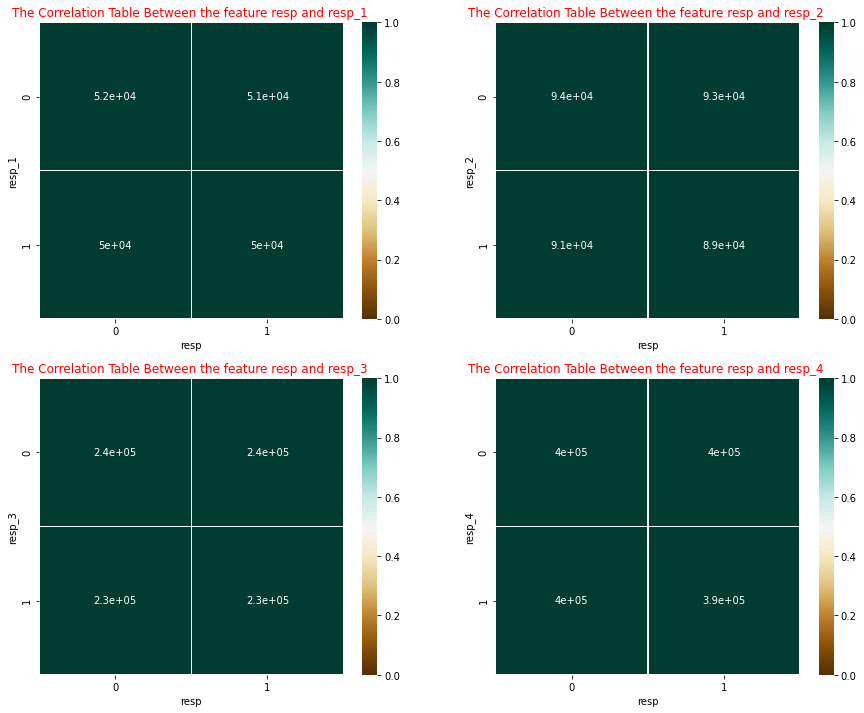

In [23]:
#
returns = ["resp_1","resp_2","resp_3","resp_4","resp"]
                                                             
datas = pd.DataFrame({c:(train_df[c]>0).astype("int") for c in returns})
datas["val"] = datas.loc[:,"resp"].values
fig , ax = plt.subplots(2,2,figsize= (15,12))
for i in range(len(returns)-1):
    k = i // 2
    l = i % 2
    piv_resp_1_resp = pd.pivot_table(datas,index= returns[i],columns="resp",values="val",aggfunc="count")
    ty = datas["resp"].value_counts()
    tx = datas[returns[i]].value_counts()
    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    ind = piv_resp_1_resp.index
    col = piv_resp_1_resp.columns
    tx.columns = ["values"]
    ty.columns = ["values"]
    n = len(datas)
    cnt = tx.dot(ty.T)/n
    cnt = cnt.loc[ind,col]
    mesure = (cnt - piv_resp_1_resp) ** 2 /cnt
    xid = mesure.sum().sum()
    mesure = mesure 
    sns.heatmap(mesure,annot=True,linewidths=0.5,cmap="BrBG",ax=ax[k,l],vmin=0,vmax=1)
    ax[k,l].set_title("The Correlation Table Between the feature resp and {} ".\
                      format(returns[i]),size=12,color="red")
    print("The total correlation between the feature {} and the resp feature equal to {}".\
          format(returns[i],xid))

In [24]:
# Define new feature named action , which can help investor to make decidion.

train_df["action"] = ((train_df["resp"] > 0) & (train_df["resp_1"] >0) & (train_df["resp_2"]>0)\
                     & (train_df["resp_3"]>0) & (train_df["resp_4"]>0)).astype("int")

In [25]:
# Let's take a look at the features data 
features.head()

feature  tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
0  feature_0  False  False  False  False  False  False  False  False  False   
1  feature_1  False  False  False  False  False  False   True   True  False   
2  feature_2  False  False  False  False  False  False   True   True  False   
3  feature_3  False  False  False  False  False  False   True  False   True   
4  feature_4  False  False  False  False  False  False   True  False   True   

   ...  tag_19  tag_20  tag_21  tag_22  tag_23  tag_24  tag_25  tag_26  \
0  ...   False   False   False   False   False   False   False   False   
1  ...   False   False   False   False   False   False   False   False   
2  ...   False   False   False   False   False   False   False   False   
3  ...   False   False   False   False   False   False   False   False   
4  ...   False   False   False   False   False   False   False   False   

   tag_27  tag_28  
0   False   False  
1   False   False  
2   False   False  
3   False   False  
4   False   False  

[5 rows x 30 columns]

In [26]:
# some statistics on the datas.
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 30 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  130 non-null    object
 1   tag_0    130 non-null    bool  
 2   tag_1    130 non-null    bool  
 3   tag_2    130 non-null    bool  
 4   tag_3    130 non-null    bool  
 5   tag_4    130 non-null    bool  
 6   tag_5    130 non-null    bool  
 7   tag_6    130 non-null    bool  
 8   tag_7    130 non-null    bool  
 9   tag_8    130 non-null    bool  
 10  tag_9    130 non-null    bool  
 11  tag_10   130 non-null    bool  
 12  tag_11   130 non-null    bool  
 13  tag_12   130 non-null    bool  
 14  tag_13   130 non-null    bool  
 15  tag_14   130 non-null    bool  
 16  tag_15   130 non-null    bool  
 17  tag_16   130 non-null    bool  
 18  tag_17   130 non-null    bool  
 19  tag_18   130 non-null    bool  
 20  tag_19   130 non-null    bool  
 21  tag_20   130 non-null    bool  
 22  ta

In [27]:
# Change the type of features dataframe to int.
features.set_index('feature',inplace=True)
features = features.astype("int8")

In [28]:
features.head()

tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
feature                                                                    
feature_0      0      0      0      0      0      0      0      0      0   
feature_1      0      0      0      0      0      0      1      1      0   
feature_2      0      0      0      0      0      0      1      1      0   
feature_3      0      0      0      0      0      0      1      0      1   
feature_4      0      0      0      0      0      0      1      0      1   

           tag_9  ...  tag_19  tag_20  tag_21  tag_22  tag_23  tag_24  tag_25  \
feature           ...                                                           
feature_0      0  ...       0       0       0       0       0       0       0   
feature_1      0  ...       0       0       0       0       0       0       0   
feature_2      1  ...       0       0       0       0       0       0       0   
feature_3      0  ...       0       0       0       0       0       0       0   
feature_4      1  ...       0       0       0       0       0       0       0   

           tag_26  tag_27  tag_28  
feature                            
feature_0       0       0       0  
feature_1       0       0       0  
feature_2       0       0       0  
feature_3       0       0       0  
feature_4       0       0       0  

[5 rows x 29 columns]

In [29]:
#T_sne implementation
t_sne = tsne(n_components=2,random_state=42).fit_transform(features.values)

Text(0.5, 0.98, 'Dimmensionality Reduction using TSNE technique')

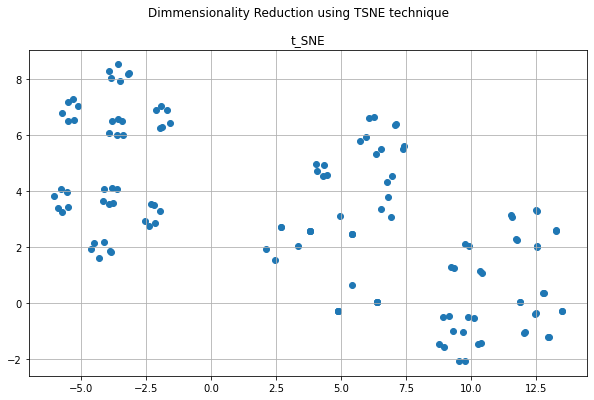

In [30]:
# Plotting the embedding of features datas in two dimension using the technique of TSNE.
fig,ax = plt.subplots(1,1,figsize=(10,6))
plt.scatter(t_sne[:,0],t_sne[:,1],cmap="coolwarm")
plt.grid(True)
plt.title("t_SNE")
plt.suptitle("Dimmensionality Reduction using TSNE technique")

==> The chart of Dimmensionality Reduction above , shows that the datas can be divided into some number of clusters. Indeed, we notice obviously, many accumulation of points, which are distant and they can be considered as a separated clusters.

In [31]:
# We will choice the best number of cluster, who can give best performance using 
# silhoute coefficient.

clusters_number = [4,8,12,16,20,24,28] # number of clusters to test in order to choice the best one.
silhouette_performances = {} # Dictionnary of performance.

for cl_n in clusters_number :
    kmeans = KMeans(n_clusters=cl_n)
    kmeans.fit(features.values)
    sc=silhouette_score(features.values,kmeans.labels_)
    silhouette_performances[sc] = cl_n

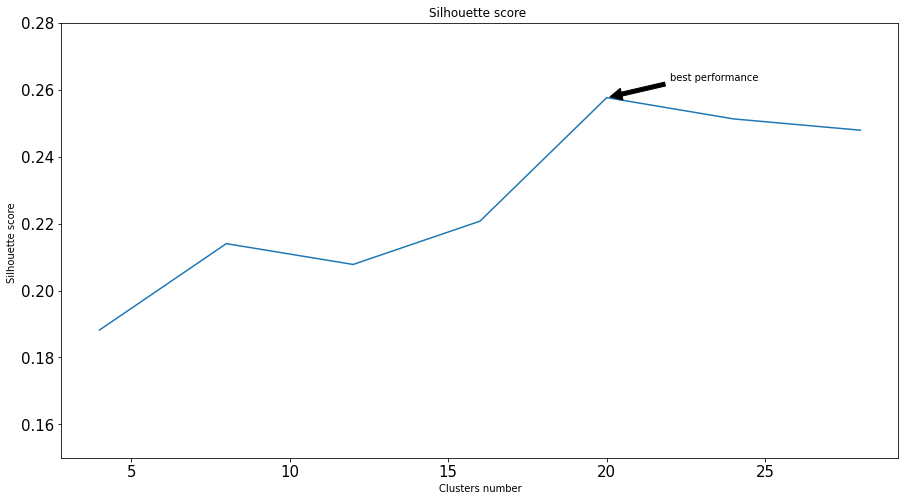

In [32]:
# plot the the cluster performances in function of the number of clusters.
fig,ax = plt.subplots(1,1,figsize=(15,8))
plt.plot(list(silhouette_performances.values()),list(silhouette_performances.keys()))
plt.title("Silhouette score ")
plt.xlabel("Clusters number",fontsize=10)
plt.ylabel("Silhouette score ",fontsize=10)
plt.ylim([0.15,0.28])
best_performace = np.max(list(silhouette_performances.keys()))
ab = silhouette_performances[best_performace]
text = "best performance"
plt.annotate(text,xy=(ab,best_performace),arrowprops=dict(facecolor='black', shrink=0.05),\
            xytext=(ab+2,best_performace + 0.005))
plt.tick_params(axis="x",labelsize=15)
plt.tick_params(axis="y",labelsize=15)

In [33]:
best_model = KMeans(n_clusters=20, n_jobs=-1)
best_model.fit(features.values)

KMeans(n_clusters=20, n_jobs=-1)

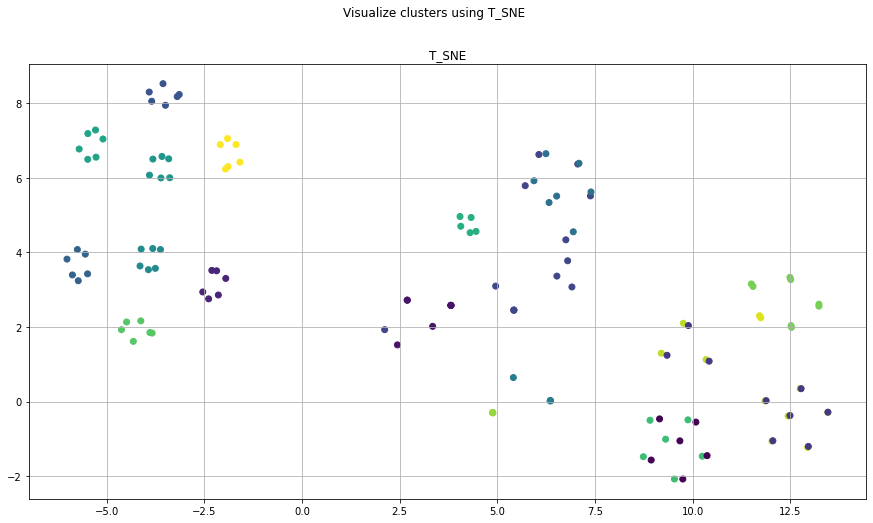

In [34]:
fig,ax = plt.subplots(1,1,figsize=(15,8))
plt.scatter(t_sne[:,0],t_sne[:,1],c=best_model.labels_)
plt.suptitle("Visualize clusters using T_SNE")
plt.title("T_SNE")
plt.grid(True)

In [35]:
train_df = train_df.query('date > 85').reset_index(drop = True) 


In [36]:
features = list(train_df.columns) # list of retaind features 
features.remove("weight")
features.remove("resp_1")
features.remove("resp_2")
features.remove("resp_3")
features.remove("resp_4")
features.remove("resp")
features.remove("action")
features.remove("ts_id")
features.remove("date")
features.remove("feature_0")

In [37]:
def save_pickle(dict_param,nom_fich):
    with open(nom_fich,"wb") as f :
        pickle.dump(dict_param,f)

In [38]:
fig=px.pie(train_df.loc[train_df["weight"] > 0,:],names="action",title="Class imballance")
fig.update_layout(title={"x":0.475,"y":0.9,"xanchor":"center","yanchor":"top"})

In [39]:
abundant_class = train_df.loc[(train_df["weight"] > 0) & (train_df["action"]==0),:] # extract datas which concern abundant datas
rare_class = train_df.loc[(train_df["weight"] > 0)&(train_df["action"]==1),:]   # extract datas which concern rares datas.

In [40]:
# The mean values of each feature to use in order to impute missing values in real production.
imputer = np.mean(train_df[features].values,axis=0)
save_pickle(imputer,"features_imputation")

In [41]:
save_pickle(features,"features_names")

In [42]:
abundant_class = abundant_class.sample(frac=1)
rare_class = rare_class.sample(frac=1)

In [43]:
l = len(rare_class) # the size of data which concern rare class.
df1 = abundant_class.iloc[:l,:].append(rare_class) # 1st chunk of datas to train first model
df2 = abundant_class.iloc[l:2*l,:].append(rare_class) # 2nd chunk of datas to train second model
df3 = abundant_class.iloc[2*l:,:].append(rare_class) # 3nd chunk of datas to train the third model.

df1 = df1.sample(frac=1) # shuffle the datas
df2 = df2.sample(frac=1) # shuffle the datas
df3 = df3.sample(frac=1) # shuffle the datas

In [44]:
len(df1),len(df2),len(df3)

(832062, 832062, 739353)

In [45]:
# reduce the memory charge
del(train_df)
del(train)

In [46]:
# retained features and label to train differents models on differents chunk of datas.
training= [df1[features],df2[features],df3[features]] 
targets = [df1["action"],df2["action"],df3["action"]]

In [47]:
datas = []
for i in range(3):
    xtr,xval,ytr,yval = train_test_split(training[i].values,targets[i].values,test_size=0.1,\
                                        stratify=targets[i].values)
    datas.append(((xtr,ytr),(xval,yval)))

In [48]:
# refresh memory
del(df1)
del(df2)
del(df3)
del(abundant_class)
del(rare_class)
del(features_with_missing_values)
del(correlation_table)
del(missing_table)

In [49]:
gc.collect()

24676

In [50]:
models = [] # list of model , we will train 
for i in range(3):
    xtr = datas[i][0][0]
    ytr = datas[i][0][1]
    xval = datas[i][1][0]
    yval = datas[i][1][1]
    model = Sequential()
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(512,input_shape = (xtr.shape[-1],),activation='relu',kernel_regularizer = 'l2'))
    model.add(layers.Dropout(rate=0.2))
    model.add(Dense(256,activation='swish'))
    model.add(layers.Dropout(rate=0.231))
    model.add(Dense(1024,activation='swish',kernel_regularizer="l2"))
    model.add(layers.Dropout(rate=0.5))
    # model.add(Dense(2000,activation='relu',kernel_regularizer="l2"))
    # model.add(layers.Dropout(rate=0.564))
    model.add(Dense(32, activation="relu"))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(1))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("sigmoid"))

    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-2)
    model.compile(optimizer=opt, loss=loss, metrics=['AUC'])
    history = model.fit(xtr,ytr,
                        validation_data=(xval,yval),
                        batch_size=int(0.01*len(xtr)), epochs=350, 
                      callbacks=[EarlyStopping('val_loss',patience=20,restore_best_weights=True)])
    models.append(model)

Epoch 1/350
101/101 [==============================] - 7s 30ms/step - loss: 6.1911 - auc: 0.5151 - val_loss: 4.1890 - val_auc: 0.5488
Epoch 2/350
101/101 [==============================] - 2s 21ms/step - loss: 3.5706 - auc: 0.5358 - val_loss: 1.9681 - val_auc: 0.5482
Epoch 3/350
101/101 [==============================] - 2s 18ms/step - loss: 1.6849 - auc: 0.5408 - val_loss: 1.0455 - val_auc: 0.5495
Epoch 4/350
101/101 [==============================] - 2s 18ms/step - loss: 0.9739 - auc: 0.5432 - val_loss: 0.7852 - val_auc: 0.5531
Epoch 5/350
101/101 [==============================] - 2s 18ms/step - loss: 0.7740 - auc: 0.5408 - val_loss: 0.7208 - val_auc: 0.5552
Epoch 6/350
101/101 [==============================] - 2s 18ms/step - loss: 0.7230 - auc: 0.5465 - val_loss: 0.7114 - val_auc: 0.5496
Epoch 7/350
101/101 [==============================] - 2s 19ms/step - loss: 0.7171 - auc: 0.5368 - val_loss: 0.7203 - val_auc: 0.5549
Epoch 8/350
101/101 [==============================] - 2s 18ms

In [51]:
import janestreet


In [52]:
janestreet.competition.make_env.__called__ = False
env = janestreet.make_env()
th = 0.5000
for (test_df, pred_df) in tqdm(env.iter_test()):
    if test_df["weight"].item() > 0 :
        x_tt = test_df.loc[:, features].values
        if np.isnan(x_tt.sum()):
           x_tt = np.nan_to_num(x_tt) + np.isnan(x_tt) * imputer
        pred = np.mean(np.stack([model(x_tt, training=False) for model in models]),axis=0).T
        pred_df.action = np.where(pred >= th, 1, 0).astype(int)
    else :
        pred_df.action = 0
    
    env.predict(pred_df)

15219it [07:03, 35.95it/s]
